In [24]:
from plot_utils import *
import pandas as pd
import numpy as np
import datetime
import os


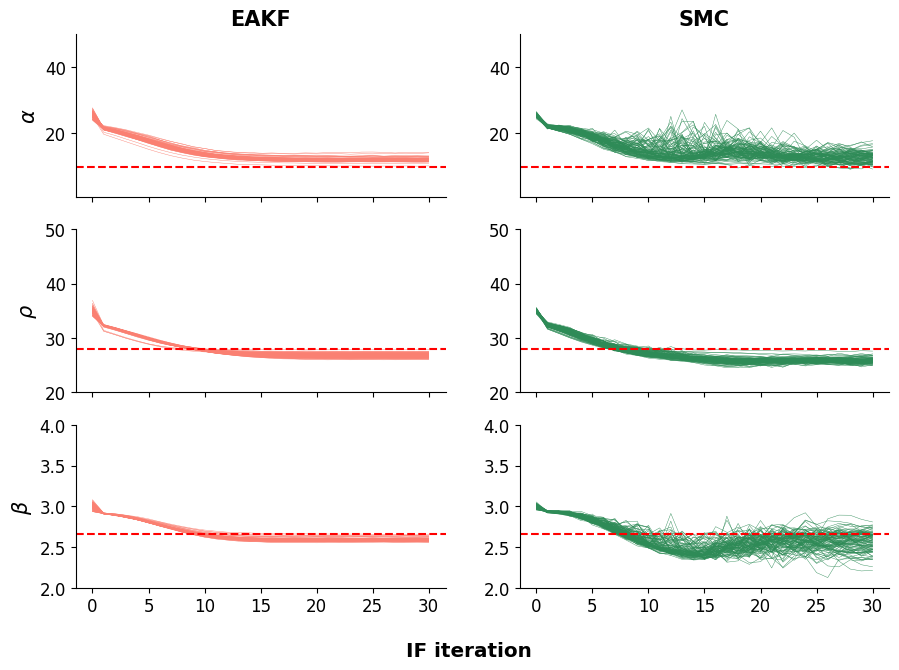

In [25]:
results_dir = 'results'

eakf_dir = os.path.join(results_dir, 'eakf')
pf_dir   = os.path.join(results_dir, 'inference', 'pf')

αmin = 1
αmax = 50

ρmin = 20
ρmax = 50

βmin = 2
βmax = 4
parameters_range  = np.array([[αmin, αmax],
                              [ρmin, ρmax],
                              [βmin, βmax]])
θ_truth = [10, 28, 8/3]

fig, ax = plt.subplots(3, 2, figsize=(10.5, 7.2), sharex=True)

for i in range(0, 99+1):
    i_file     = str(i).zfill(3)
    infer_file = os.path.join(eakf_dir, '{}_infer.npz'.format(i_file))

    infer = np.load(infer_file)
    θmle  = infer['θmle']

    ax[0, 0].plot(range(30+1), θmle[0, :], label='True', color="salmon", lw=0.3)
    ax[1, 0].plot(range(30+1), θmle[1, :], label='True', color="salmon", lw=0.3)
    ax[2, 0].plot(range(30+1), θmle[2, :], label='True', color="salmon", lw=0.3)

    infer_file = os.path.join(pf_dir, '{}_infer.npz'.format(i_file))
    infer = np.load(infer_file)
    θmle  = infer['θmle']

    ax[0, 1].plot(range(30+1), θmle[0, :], label='True', color="seagreen", lw=0.3)
    ax[1, 1].plot(range(30+1), θmle[1, :], label='True', color="seagreen", lw=0.3)
    ax[2, 1].plot(range(30+1), θmle[2, :], label='True', color="seagreen", lw=0.3)

p_label = ['α', 'ρ', 'β']
for p in range(3):
    ax[p,0].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,0].set_ylim(parameters_range[p])
    ax[p,1].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,1].set_ylim(parameters_range[p])

    ax[p, 0].set_ylabel(r'${}$'.format(p_label[p]))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0, 0].set_title('EAKF', weight="bold", fontsize=15)
ax[0, 1].set_title('SMC', weight="bold", fontsize=15)

fig.supxlabel("IF iteration", weight='bold')

fig.savefig('figures/convergence_mean.png', dpi=300, bbox_inches='tight', transparent=True)

In [26]:
for i in range(0, 99+1):
    i_file     = str(i).zfill(3)
    infer_file = os.path.join(eakf_dir, '{}_infer.npz'.format(i_file))

    infer = np.load(infer_file)
    θpost = infer['θpost']

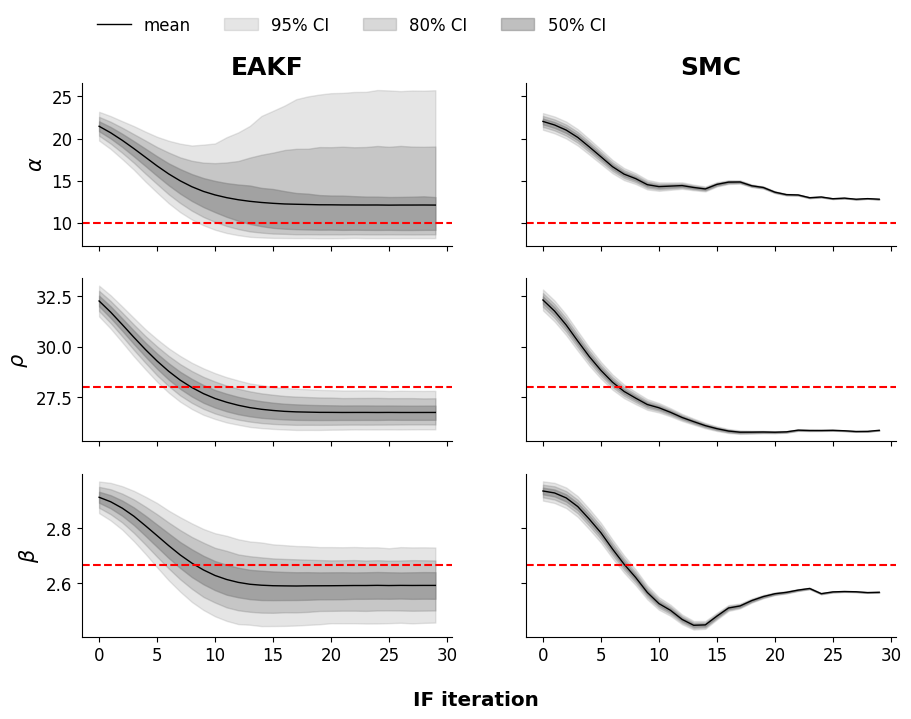

In [27]:
import sys
sys.path.insert(0, "pompjax/pompjax")

from utils import create_df_response

αmin = 1
αmax = 50

ρmin = 20
ρmax = 35

βmin = 2
βmax = 4
parameters_range  = np.array([[αmin, αmax],
                              [ρmin, ρmax],
                              [βmin, βmax]])

fig, ax = plt.subplots(3, 2, figsize=(10.5, 7.2), sharex=True, sharey="row")

for idir, dir in enumerate([eakf_dir, pf_dir]):
    α_df = []
    ρ_df = []
    β_df = []

    for i in range(0, 99+1):
        i_file     = str(i).zfill(3)
        infer_file = os.path.join(dir, '{}_infer.npz'.format(i_file))
        θpost = np.load(infer_file)["θpost"]

        df1 = create_df_response(θpost[0, :, :].T, time=30); df1["idx_inf"] = i
        df2 = create_df_response(θpost[1, :, :].T, time=30); df2["idx_inf"] = i
        df3 = create_df_response(θpost[2, :, :].T, time=30); df3["idx_inf"] = i

        α_df.append(df1.drop(columns=["type"]))
        ρ_df.append(df2.drop(columns=["type"]))
        β_df.append(df3.drop(columns=["type"]))

    α_df = pd.concat(α_df).reset_index(); α_df = α_df.groupby("date").mean().reset_index()
    ρ_df = pd.concat(ρ_df).reset_index(); ρ_df = ρ_df.groupby("date").mean().reset_index()
    β_df = pd.concat(β_df).reset_index(); β_df = β_df.groupby("date").mean().reset_index()

    ax[0, idir].plot(α_df["date"], α_df["mean"], color="k", lw=1, label="mean")
    ax[0, idir].fill_between(α_df["date"], α_df["high_95"], α_df["low_95"], color="gray", alpha=0.2, label="95% CI")
    ax[0, idir].fill_between(α_df["date"], α_df["high_80"], α_df["low_80"], color="gray", alpha=0.3, label="80% CI")
    ax[0, idir].fill_between(α_df["date"], α_df["high_50"], α_df["low_50"], color="gray", alpha=0.5, label="50% CI")

    ax[1, idir].plot(ρ_df["date"], ρ_df["mean"], color="k", lw=1)
    ax[1, idir].fill_between(ρ_df["date"], ρ_df["high_95"], ρ_df["low_95"], color="gray", alpha=0.2)
    ax[1, idir].fill_between(ρ_df["date"], ρ_df["high_80"], ρ_df["low_80"], color="gray", alpha=0.3)
    ax[1, idir].fill_between(ρ_df["date"], ρ_df["high_50"], ρ_df["low_50"], color="gray", alpha=0.5)

    ax[2, idir].plot(β_df["date"], β_df["mean"], color="k", lw=1)
    ax[2, idir].fill_between(β_df["date"], β_df["high_95"], β_df["low_95"], color="gray", alpha=0.2)
    ax[2, idir].fill_between(β_df["date"], β_df["high_80"], β_df["low_80"], color="gray", alpha=0.3)
    ax[2, idir].fill_between(β_df["date"], β_df["high_50"], β_df["low_50"], color="gray", alpha=0.5)

for p in range(3):
    ax[p,0].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,1].axhline(y=θ_truth[p], color='red', ls='--')

    #ax[p,0].set_ylim(parameters_range[p])
    #ax[p,1].set_ylim(parameters_range[p])

    ax[p, 0].set_ylabel(r'${}$'.format(p_label[p]))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0, 0].legend(loc='upper left', frameon=False, bbox_to_anchor=(0.0, 1.5), ncol=4)
ax[0, 0].set_title('EAKF', weight="bold")
ax[0, 1].set_title('SMC', weight="bold")

fig.supxlabel("IF iteration", weight='bold')

fig.savefig('figures/convergence_distribution.png', dpi=300, bbox_inches='tight', transparent=True)

In [28]:
all_df = []

for i in range(1, 99+1):

    i_file     = str(i).zfill(3)
    infer_file = os.path.join(eakf_dir, '{}_infer.npz'.format(i_file))

    infer = np.load(infer_file)
    θpost = infer["θpost"][:,:,-1]

    df = pd.DataFrame.from_dict({'α': θpost[0,:], 'ρ': θpost[1,:], 'β': θpost[2,:], "idx": [i]*θpost.shape[1]}, orient='index').T
    df["method"] = "EAKF"
    df["ens_id"] = np.arange(θpost.shape[1])
    all_df.append(df)

    infer_file = os.path.join(pf_dir, '{}_infer.npz'.format(i_file))
    infer = np.load(infer_file)
    θpost = infer["θpost"][:,:,-1]

    df = pd.DataFrame.from_dict({'α': θpost[0,:], 'ρ': θpost[1,:], 'β': θpost[2,:],"idx": [i]*θpost.shape[1]}, orient='index').T
    df["method"] = "PF"
    df["ens_id"] = np.arange(θpost.shape[1])
    all_df.append(df)

mle_df = pd.concat(all_df)
mle_df = mle_df.sort_values(by=['method', "idx"])

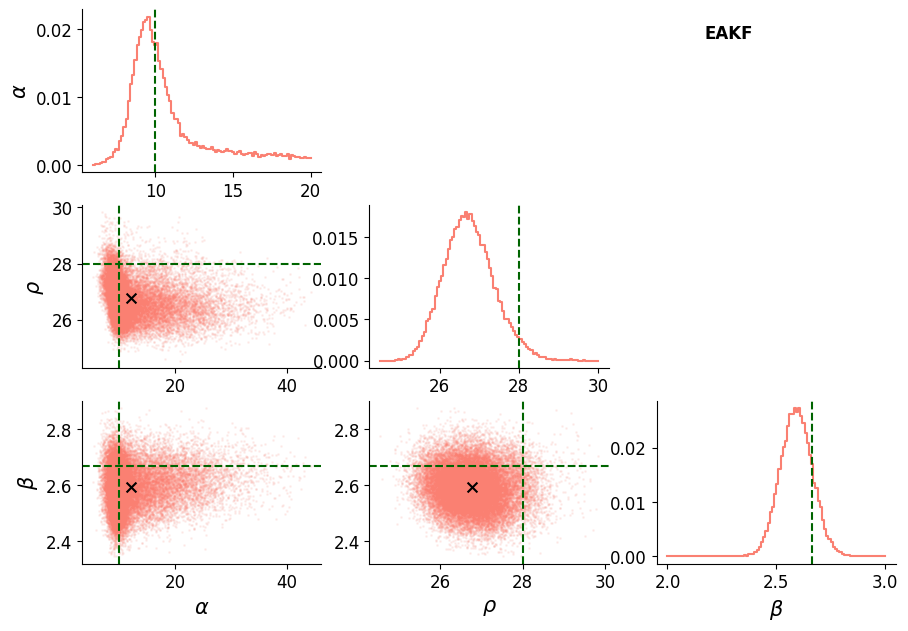

In [29]:
from scipy.ndimage import gaussian_filter

p_range = [ (6 , 20), (24.5, 30), (2, 3)]

cols = ['α', 'ρ', 'β']

fig, ax = plt.subplots(3, 3, figsize=(10.5, 7.2), sharex=False, sharey=False)

for p in range(3):
    eakf_df = mle_df[mle_df['method'] == 'EAKF']
    pf_df   = mle_df[mle_df['method'] == 'PF']

    bins_1d = np.linspace(p_range[p][0], p_range[p][1],  100+1)
    x, _    = np.histogram(eakf_df[cols[p]].values, bins=bins_1d)

    x0 = np.array(list(zip(bins_1d[:-1], bins_1d[1:]))).flatten()
    y0 = np.array(list(zip(x, x))).flatten()

    ax[p, p].plot(x0, y0/np.sum(y0), color="salmon")
    ax[p, p].axvline(x=θ_truth[p], color='darkgreen', ls='--')

for p in range(3):
    ax[p, 0].set_ylabel(r'${}$'.format(cols[p]))
    ax[-1, p].set_xlabel(r'${}$'.format(cols[p]))

for pi in range(3):
    for pj in range(3):
        if pi>pj:
            p1_df = eakf_df[[cols[pi], cols[pj], "idx"]]
            ax[pi, pj].scatter(p1_df[cols[pj]], p1_df[cols[pi]], color="salmon", s=1, alpha=0.1)

            ax[pi, pj].scatter(np.mean(p1_df[cols[pj]]), np.mean(p1_df[cols[pi]]), marker="x", color="k", s=50, alpha=1)

            ax[pi, pj].axhline(y=θ_truth[pi], color='darkgreen', ls='--')
            ax[pi, pj].axvline(x=θ_truth[pj], color='darkgreen', ls='--')

        elif pi<pj:
            ax[pi, pj].remove()

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
ax[0, 0].text(2.7, 0.85, 'EAKF', horizontalalignment='center',
              verticalalignment='center', transform=ax[0, 0].transAxes, weight='bold')

fig.savefig('figures/corner_eakf.png', dpi=300, bbox_inches='tight', transparent=True)

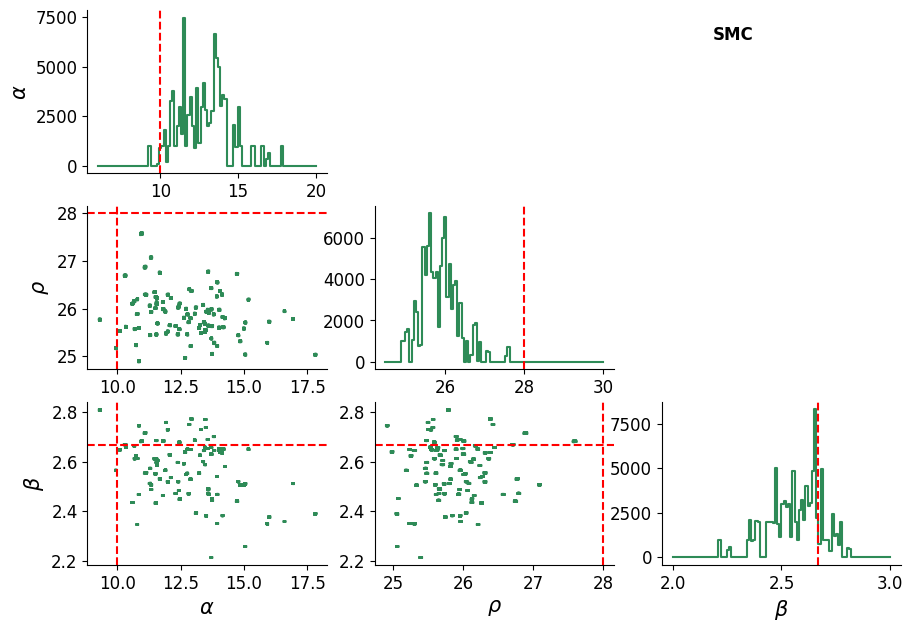

In [30]:
from scipy.ndimage import gaussian_filter

p_range = [ (6 , 20), (24.5, 30), (2, 3)]

cols = ['α', 'ρ', 'β']

fig, ax = plt.subplots(3, 3, figsize=(10.5, 7.2), sharex=False, sharey=False)

for p in range(3):
    eakf_df = mle_df[mle_df['method'] == 'EAKF']
    pf_df   = mle_df[mle_df['method'] == 'PF']


    bins_1d = np.linspace(p_range[p][0], p_range[p][1],  100+1)
    x, _    = np.histogram(pf_df[cols[p]].values, bins=bins_1d)

    x0 = np.array(list(zip(bins_1d[:-1], bins_1d[1:]))).flatten()
    y0 = np.array(list(zip(x, x))).flatten()
    ax[p, p].plot(x0, y0, color="seagreen")
    ax[p, p].axvline(x=θ_truth[p], color='red', ls='--')

for p in range(3):
    ax[p, 0].set_ylabel(r'${}$'.format(cols[p]))
    ax[-1, p].set_xlabel(r'${}$'.format(cols[p]))

for pi in range(3):
    for pj in range(3):
        if pi>pj:
            p1_df = pf_df[[cols[pi], cols[pj], "idx"]]
            ax[pi, pj].scatter(p1_df[cols[pj]], p1_df[cols[pi]], color="seagreen", s=1, alpha=0.1)

            ax[pi, pj].axhline(y=θ_truth[pi], color='red', ls='--')
            ax[pi, pj].axvline(x=θ_truth[pj], color='red', ls='--')

        elif pi<pj:
            ax[pi, pj].remove()

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0, 0].text(2.7, 0.85, 'SMC', horizontalalignment='center',
              verticalalignment='center', transform=ax[0, 0].transAxes, weight='bold')

fig.savefig('figures/corner_SMC.png', dpi=300, bbox_inches='tight', transparent=True)

In [138]:
from pyro.contrib.forecast.evaluate import eval_crps
from pyro.ops.stats import crps_empirical
import torch

θ_truth

p_lab = ['α', 'ρ', 'β']
crps_df = pd.DataFrame(columns=["method", "idx", "parameter", "crps"])

for ip, p in enumerate(p_lab):
    for method in ["EAKF", "PF"]:
        p_df = mle_df[mle_df.method==method][[p, "idx"]]
        crps_val = np.array(crps_empirical(torch.tensor(p_df.pivot(columns="idx", values=p).to_numpy()), torch.tensor(np.ones((99))*θ_truth[ip])))

        df      = pd.DataFrame.from_dict({"method": method, "idx": np.arange(1, 99+1), "parameter": p, "crps": crps_val})
        crps_df = pd.concat([crps_df, df]).reset_index(drop=True)
crps_mean_df = crps_df.groupby(["method", "parameter"]).mean().reset_index().pivot_table(index="method", columns="parameter", values="crps")
crps_std_df  = crps_df[["method", "parameter", "crps"]].groupby(["method", "parameter"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_2": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/3730122448.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crps_df = pd.concat([crps_df, df]).reset_index(drop=True)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/1484603861.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[ip].scatter(crps_mean_df[p][0], [1.2], color="salmon", s=40, marker="s")
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/1484603861.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[ip].scatter(crps_mean_df[p][1], [1.8], color="seagreen", s=40, marker="s")
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/1484603861.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

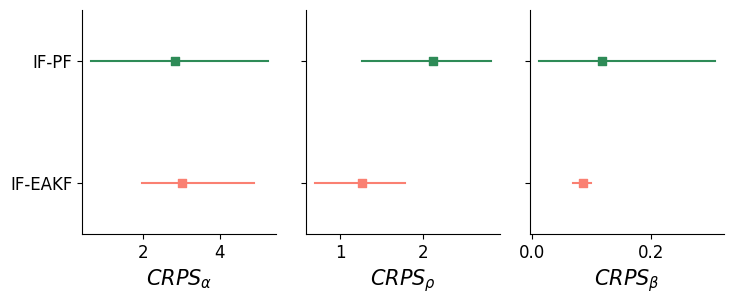

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(7.5, 3.2), sharex=False, sharey=True)

for ip, p in enumerate(p_lab):

    p_q_df = crps_std_df.query("parameter == '{}'".format(p))
    arr = p_q_df.pivot(index="method", columns="stat", values="crps").to_numpy()

    ax[ip].plot(arr[0], [1.2, 1.2], color="salmon")
    ax[ip].plot(arr[1], [1.8, 1.8], color="seagreen")

    ax[ip].scatter(crps_mean_df[p][0], [1.2], color="salmon", s=40, marker="s")
    ax[ip].scatter(crps_mean_df[p][1], [1.8], color="seagreen", s=40, marker="s")

    ax[ip].set_xlabel(r"$CRPS_{}$".format(p))

    ax[ip].set_yticks([1.2, 1.8])
    ax[ip].set_ylim((0.95, 2.05))
    ax[ip].set_yticklabels(["IF-EAKF", "IF-PF"])

    ax[ip].spines['right'].set_visible(False)
    ax[ip].spines['top'].set_visible(False)

plt.tight_layout()

fig.savefig('figures/crps_distribution.png', dpi=300, bbox_inches='tight', transparent=True)

In [143]:
θ_truth

p_lab = ['α', 'ρ', 'β']
mae_df = pd.DataFrame(columns=["method", "idx", "parameter", "crps"])

for ip, p in enumerate(p_lab):
    for method in ["EAKF", "PF"]:
        p_df = mle_df[mle_df.method==method][[p, "idx"]]

        mae_val = np.mean(np.abs(p_df.pivot(columns="idx", values=p).to_numpy() - np.ones((99))*θ_truth[ip]),0)

        df       = pd.DataFrame.from_dict({"method": method, "idx": np.arange(1, 99+1), "parameter": p, "mae": mae_val})
        mae_df  = pd.concat([mae_df, df]).reset_index(drop=True)

mae_mean_df = mae_df.groupby(["method", "parameter"]).mean().reset_index().pivot_table(index="method", columns="parameter", values="mae")
mae_std_df  = mae_df[["method", "parameter", "mae"]].groupby(["method", "parameter"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_2": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/617938084.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[ip].scatter(mae_mean_df[p][0], [1.2], color="salmon", s=40, marker="s")
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/617938084.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[ip].scatter(mae_mean_df[p][1], [1.8], color="seagreen", s=40, marker="s")
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_44036/617938084.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

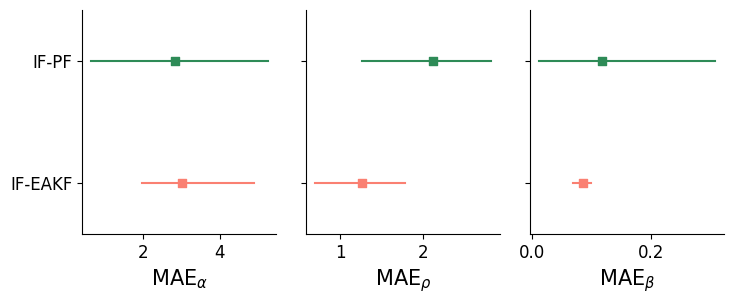

In [149]:
fig, ax = plt.subplots(1, 3, figsize=(7.5, 3.2), sharex=False, sharey=True)

for ip, p in enumerate(p_lab):

    p_q_df = mae_std_df.query("parameter == '{}'".format(p))
    arr = p_q_df.pivot(index="method", columns="stat", values="mae").to_numpy()

    ax[ip].plot(arr[0], [1.2, 1.2], color="salmon")
    ax[ip].plot(arr[1], [1.8, 1.8], color="seagreen")

    ax[ip].scatter(mae_mean_df[p][0], [1.2], color="salmon", s=40, marker="s")
    ax[ip].scatter(mae_mean_df[p][1], [1.8], color="seagreen", s=40, marker="s")

    ax[ip].set_xlabel(r"MAE$_{}$".format(p))

    ax[ip].set_yticks([1.2, 1.8])
    ax[ip].set_ylim((0.95, 2.05))
    ax[ip].set_yticklabels(["IF-EAKF", "IF-PF"])

    ax[ip].spines['right'].set_visible(False)
    ax[ip].spines['top'].set_visible(False)

plt.tight_layout()

fig.savefig('figures/mae_distribution.png', dpi=300, bbox_inches='tight', transparent=True)